In [1]:
import os
import numpy as np
import tensorflow as tf
from keras_contrib.layers import InstanceNormalization
tf.__version__

'2.0.0-alpha0'

In [2]:
!which jupyter

/Users/meng.lee/anaconda3/envs/cartoonize/bin/jupyter


In [3]:
!pip freeze | grep keras

tf-keras-contrib==2.0.8


## Instance Norm check

In [18]:
NUMPY_WEIGHTS_DIR = "pretrained_weights"
style = 'shinkai'
name = 'in13_1'

In [19]:
model = tf.keras.Sequential()

epsilon = 1e-9
init_beta = np.load("pretrained_weights/shinkai/in13_1.shift.npy")
init_gamma = np.load("pretrained_weights/shinkai/in13_1.scale.npy")

model.add(InstanceNormalization(
            axis=-1,
            epsilon=epsilon, 
            beta_initializer=tf.keras.initializers.constant(init_beta),
            gamma_initializer=tf.keras.initializers.constant(init_gamma),
        ))

In [20]:
np.random.seed(9527)
chs = 64
nx = np.random.randn(2, 64, 64, chs).astype(np.float32)

model.build(input_shape=nx.shape)

In [21]:
out = model(nx)

In [23]:
model.save("in_model.h5")
custom_objects = {'InstanceNormalization': InstanceNormalization}
inf_model = load_model("in_model.h5", custom_objects, compile=False)

## Conv check

In [98]:
prev_chs = 3
chs = 64
k_size = 7
pad = 0

init_weight = np.load("pretrained_weights/shinkai/conv01_1.weight.npy")
init_weight = np.transpose(init_weight, [2, 3, 1, 0])
init_bias = np.load("pretrained_weights/shinkai/conv01_1.bias.npy")

model = tf.keras.Sequential()

if pad > 0:
    model.add(tf.keras.layers.ZeroPadding2D(padding=(pad, pad)))

model.add(tf.keras.layers.Conv2D(
            filters=chs,
            kernel_size=k_size,
            kernel_initializer=tf.keras.initializers.constant(init_weight),
            bias_initializer=tf.keras.initializers.constant(init_bias)
        ))

In [99]:
np.random.seed(9527)
nx = np.random.randn(2, 64, 64, prev_chs).astype(np.float32)
model.build(input_shape=nx.shape)

In [102]:
out = model(nx)

## Deconv

In [104]:
init_weight = np.load("pretrained_weights/shinkai/deconv02_1.weight.npy")
init_weight = np.transpose(init_weight, [2, 3, 1, 0])
init_bias = np.load("pretrained_weights/shinkai/deconv02_1.bias.npy")


prev_chs = 128
chs = 64
k_size = 3
stride = 2
padding = 1

In [106]:
model = tf.keras.Sequential()

model.add(
    tf.keras.layers.Conv2DTranspose(
        filters=chs,
        kernel_size=k_size,
        strides=(stride, stride),
        kernel_initializer=tf.keras.initializers.constant(init_weight),
        bias_initializer=tf.keras.initializers.constant(init_bias)
    )
)
        
model.add(
    tf.keras.layers.Cropping2D(
        cropping=((1, 0), (1, 0))
    )
)

In [107]:
np.random.seed(9527)
nx = np.random.randn(2, 64, 64, prev_chs).astype(np.float32)
model.build(input_shape=nx.shape)

In [109]:
out = model(nx)

## Build Model

- reflection pad try
- 去掉 `None` 

In [4]:
def add_conv_layer(model, style, name, filters, kernel_size, strides=(1, 1), pad=0, bias=True):
    init_weight = np.load(f"pretrained_weights/{style}/{name}.weight.npy")
    init_weight = np.transpose(init_weight, [2, 3, 1, 0])
    init_bias = np.load(f"pretrained_weights/{style}/{name}.bias.npy")
    
    if pad > 0 and model:
        model.add(tf.keras.layers.ZeroPadding2D(padding=(pad, pad)))
    if bias:
        bias_initializer = tf.keras.initializers.constant(init_bias)
    else:
        bias_initializer = "zeros"
        
    layer = tf.keras.layers.Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        kernel_initializer=tf.keras.initializers.constant(init_weight),
        bias_initializer=bias_initializer
    )
    if model:
        model.add(layer)
    return layer


def add_instance_norm_layer(model, style, name, epsilon=1e-9):
    init_beta = np.load(f"pretrained_weights/{style}/{name}.shift.npy")
    init_gamma = np.load(f"pretrained_weights/{style}/{name}.scale.npy")

    layer = InstanceNormalization(
        axis=-1,
        epsilon=epsilon, 
        beta_initializer=tf.keras.initializers.constant(init_beta),
        gamma_initializer=tf.keras.initializers.constant(init_gamma)
    )  
    if model:
        model.add(layer)
    return layer


def add_deconv_layers(model, style, name, filters, kernel_size, strides=(1, 1)):
    
    init_weight = np.load(f"pretrained_weights/{style}/{name}.weight.npy")
    init_weight = np.transpose(init_weight, [2, 3, 1, 0])
    init_bias = np.load(f"pretrained_weights/{style}/{name}.bias.npy")
    
    layers = []
    layers.append(tf.keras.layers.Conv2DTranspose(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        kernel_initializer=tf.keras.initializers.constant(init_weight),
        bias_initializer=tf.keras.initializers.constant(init_bias)
    ))
    
    layers.append(tf.keras.layers.Cropping2D(cropping=((1, 0), (1, 0))))
    
    if model:
        for layer in layers:
            model.add(layer)
    return layers


def build_generator(style="shinkai"):
    
    inputs = tf.keras.Input(shape=(None, None, 3))
        
    y = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(inputs)
    y = add_conv_layer(None, style, "conv01_1", filters=64, kernel_size=7)(y)
    y = add_instance_norm_layer(None, style, "in01_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = add_conv_layer(None, style, "conv02_1", filters=128, kernel_size=3, strides=(2, 2))(y)
    y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = add_conv_layer(None, style, "conv02_2", filters=128, kernel_size=3, strides=(1, 1))(y)
    y = add_instance_norm_layer(None, style, "in02_1")(y)
    y = tf.keras.layers.Activation("relu")(y)

    y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = add_conv_layer(None, style, "conv03_1", filters=256, kernel_size=3, strides=(2, 2))(y)
    y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = add_conv_layer(None, style, "conv03_2", filters=256, kernel_size=3, strides=(1, 1))(y)
    y = add_instance_norm_layer(None, style, "in03_1")(y)
    
    t_prev = tf.keras.layers.Activation("relu")(y)

    
    for i in range(4, 12):
        y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(t_prev)
        y = add_conv_layer(None, style, "conv%02d_1" % i, filters=256, kernel_size=3)(y)
        y = add_instance_norm_layer(None, style, "in%02d_1" % i)(y)
        y = tf.keras.layers.Activation("relu")(y)

        t = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
        t = add_conv_layer(None, style, "conv%02d_2" % i, filters=256, kernel_size=3)(t)
        t = add_instance_norm_layer(None, style, "in%02d_2" % i)(t)

        t_prev = tf.keras.layers.Add()([t, t_prev])

        if i == 11:
            y = t_prev

    layers = add_deconv_layers(None, style, "deconv01_1", filters=128, kernel_size=3, strides=(2, 2))
    for layer in layers:
        y = layer(y)
    y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = add_conv_layer(None, style, "deconv01_2", filters=128, kernel_size=3)(y)
    y = add_instance_norm_layer(None, style, "in12_1")(y)
    y = tf.keras.layers.Activation("relu")(y)
    
    layers = add_deconv_layers(None, style, "deconv02_1", filters=64, kernel_size=3, strides=(2, 2))
    for layer in layers:
        y = layer(y)
    y = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(y)
    y = add_conv_layer(None, style, "deconv02_2", filters=64, kernel_size=3)(y)
    y = add_instance_norm_layer(None, style, "in13_1")(y)
    y = tf.keras.layers.Activation("relu")(y)
    
    y = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(y)
    y = add_conv_layer(None, style, "deconv03_1", filters=3, kernel_size=7)(y)
    y = tf.keras.layers.Activation("tanh")(y)
    
    model = tf.keras.Model(inputs=inputs, outputs=y)
    
    return model

In [5]:
g = build_generator()

In [6]:
np.random.seed(9527)
nx = np.random.rand(1, 225, 225, 3).astype(np.float32)
out = g(nx)
tf_out = np.load("tf_out.npy")

diff = np.sqrt(np.mean((out - tf_out)**2))
print(f"diff: {diff}")

diff: 4.605672359048185e-07


## Transform new image

In [7]:
from PIL import Image
image_path = 'test.jpg'
input_image = Image.open(image_path).convert("RGB")

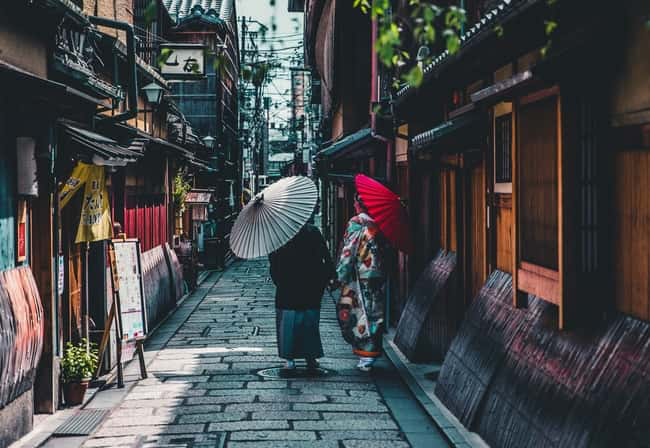

In [8]:
input_image

In [9]:
input_image = np.asarray(input_image)
input_image = input_image.astype(np.float32)
print(f"original shape of image: {input_image.shape}")
input_image = input_image[:, :, [2, 1, 0]]
input_image = np.expand_dims(input_image, axis=0)
print(f"after adding batch dim: {input_image.shape}")

original shape of image: (448, 650, 3)
after adding batch dim: (1, 448, 650, 3)


In [10]:
transformed_image = g(input_image)
transformed_image = transformed_image.numpy()
transformed_image = transformed_image[0]

In [11]:
transformed_image = transformed_image[:, :, [2, 1, 0]]
transformed_image = transformed_image * 0.5 + 0.5
transformed_image = transformed_image * 255
transformed_image_path = 'transformed.jpg'

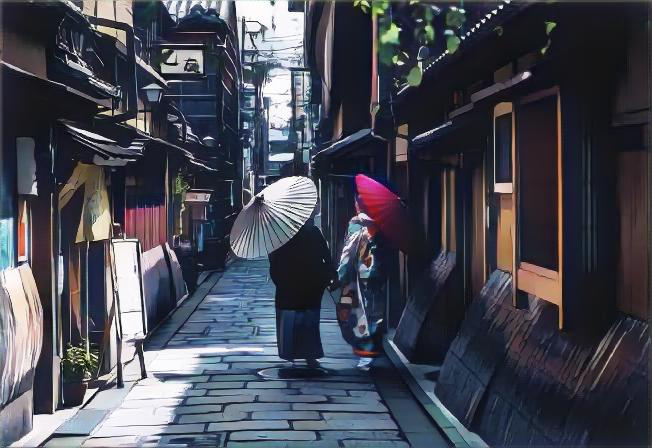

In [12]:
img = Image.fromarray(transformed_image.astype('uint8'))
img.save(transformed_image_path)
Image.open(transformed_image_path).convert("RGB")

## Save Keras Models

In [81]:
# !pip install -qq tensorflowjs

  Using cached https://files.pythonhosted.org/packages/81/07/be624c7e0a63b080a76b7f6faf417eecdc5f6480f6a740a8bcf8991bce0b/tensorflow-1.12.0-cp36-cp36m-macosx_10_11_x86_64.whl
distributed 1.21.8 requires msgpack, which is not installed.
keras 2.2.2 has requirement keras-applications==1.0.4, but you'll have keras-applications 1.0.7 which is incompatible.
keras 2.2.2 has requirement keras-preprocessing==1.0.2, but you'll have keras-preprocessing 1.0.9 which is incompatible.
  Found existing installation: tensorflow 2.0.0a0
    Uninstalling tensorflow-2.0.0a0:
      Successfully uninstalled tensorflow-2.0.0a0
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [13]:
NUMPY_WEIGHTS_DIR = "pretrained_weights"
styles = ['shinkai', 'hayao', 'paprika', 'hosoda']

In [14]:
for style in styles:
    g = build_generator(style=style)
    nx = np.random.rand(1, 225, 225, 3).astype(np.float32)
    out = g(nx)
    model_fname = f"keras_models/{style}.h5"
    g.save(model_fname)


## Freeze Models

In [38]:
for style in styles:
    keras_model_path = os.path.abspath(f"keras_models/{style}.h5")
    pb_model_path = os.path.abspath(f"pb_models/{style}.pb")
    
    !python -c "import tensorflow as tf; print(tf.__version__)"
    !python keras_to_tensorflow/keras_to_tensorflow.py\
        --input_model="{keras_model_path}"\
        --output_model="{pb_model_path}"

2.0.0-alpha0
W0403 19:28:10.671186 4325406144 deprecation.py:323] From /Users/meng.lee/anaconda3/envs/cartoonize/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:63: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term
2019-04-03 19:28:26.172593: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
I0403 19:28:28.092068 4325406144 keras_to_tensorflow.py:151] Converted output node names are: ['activation_27/Tanh']
W0403 19:28:28.223356 4325406144 deprecation.py:323] From keras_to_tensorflow/keras_to_tensorflow.py:178: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variable

## Convert pbmodels to tfjs-models

In [45]:
!which tensorflowjs_converter

/Users/meng.lee/anaconda3/envs/cartoonize/bin/tensorflowjs_converter


In [55]:
for style in styles[:1]:
    
    !tensorflowjs_converter \
        --input_format=keras \
        --output_format=tfjs_layers_model\
        keras_models/{style}.h5 \
        tfjs_pb_models/{style}
    
    
#     !/Users/meng.lee/anaconda3/envs/cartoongan/bin/tensorflowjs_converter \
#         --input_format=tf_frozen_model \
#         --output_node_names='activation_27/Tanh'\
#         pb_models/{style}.pb \
#         tfjs_pb_models/{style}
    
    
    #          \

In [58]:
!ls -alth tfjs_pb_models/shinkai/

total 665432
-rw-r--r--   1 meng.lee  staff   237M Apr  3 19:53 model.json
-rw-r--r--   1 meng.lee  staff   2.5M Apr  3 19:53 group1-shard11of11.bin
drwxr-xr-x  25 meng.lee  staff   800B Apr  3 19:53 .
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard10of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard9of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard8of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard7of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard6of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard5of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard4of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard3of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard2of11.bin
-rw-r--r--   1 meng.lee  staff   4.0M Apr  3 19:53 group1-shard1of11.bin
-rw-r--r--   1 meng.lee  staff   2.5M Apr  3 15:37 group1-shard11of

In [56]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras import backend as K
# K.clear_session()
# custom_objects = {'InstanceNormalization': InstanceNormalization}
# inf_model = load_model("shinkai.h5", custom_objects, compile=False)